<a href="https://colab.research.google.com/github/dokeyuka/deep-learning-practice/blob/main/DL_practice6_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

epoch:1, loss: 2.283, a㏄:0.160, val_loss:2.251, val_acc:0.322
epoch:2, loss: 2.098, a㏄:0.498, val_loss:1.701, val_acc:0.596
epoch:3, loss: 1.098, a㏄:0.709, val_loss:0.720, val_acc:0.789
epoch:4, loss: 0.613, a㏄:0.820, val_loss:0.501, val_acc:0.852
epoch:5, loss: 0.472, a㏄:0.864, val_loss:0.417, val_acc:0.879
epoch:6, loss: 0.407, a㏄:0.884, val_loss:0.375, val_acc:0.890
epoch:7, loss: 0.370, a㏄:0.894, val_loss:0.344, val_acc:0.900
epoch:8, loss: 0.344, a㏄:0.902, val_loss:0.324, val_acc:0.903
epoch:9, loss: 0.324, a㏄:0.908, val_loss:0.306, val_acc:0.912
epoch:10, loss: 0.306, a㏄:0.912, val_loss:0.292, val_acc:0.915
epoch:11, loss: 0.290, a㏄:0.918, val_loss:0.278, val_acc:0.919
epoch:12, loss: 0.275, a㏄:0.922, val_loss:0.264, val_acc:0.923
epoch:13, loss: 0.261, a㏄:0.926, val_loss:0.253, val_acc:0.927
epoch:14, loss: 0.249, a㏄:0.929, val_loss:0.241, val_acc:0.930
epoch:15, loss: 0.236, a㏄:0.933, val_loss:0.232, val_acc:0.933
epoch:16, loss: 0.224, a㏄:0.936, val_loss:0.218, val_acc:0.935
e

TypeError: ignored

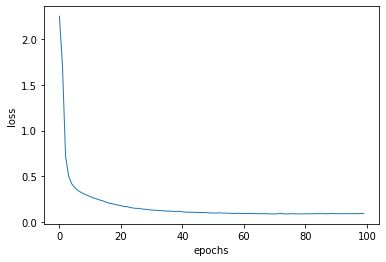

In [ ]:
import os
import numpy as np
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn 
import torch.optim as optimizers
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from matplotlib import pyplot as plt


'''
  (1) modelの実装
'''
class DNN(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super().__init__()
    self.l1 = nn.Linear(input_dim, hidden_dim)
    self.a1 = nn.ReLU()
    self.d1 = nn.Dropout(0.5)

    self.l2 = nn.Linear(hidden_dim, hidden_dim)
    self.a2 = nn.ReLU()
    self.d2 = nn.Dropout(0.5)

    self.l3 = nn.Linear(hidden_dim,hidden_dim)
    self.a3 = nn.ReLU()
    self.d3 = nn.Dropout(0.5)

    self.l4 = nn.Linear(hidden_dim, output_dim)
    
    self.layers = [self.l1, self.a1,
                    self.l2, self.a2,
                    self.l3, self.a3,
                    self.l4]

  def forward(self,x):
    for layer in self.layers:
      x = layer(x)
    return x



if __name__ == '__main__':
  np.random.seed(123)
  #torch用の乱数シード
  torch.manual_seed(123)

  #deviceに実行環境を格納して同じコードでCPUでもGPUでも対応できるように
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
'''
  1 データの準備
'''
root = os.path.join('~', '.torch', 'mnist')
#numpyをTテンensorに変換し、さらにTensorの次元を(28，28)から(784、)に変換
transform = transforms.Compose([transforms.ToTensor(), lambda x: x.view(-1)])

mnist_train = datasets.MNIST(root = root,
                             download = True,
                             train = True,
                             transform = transform)
n_samples = len(mnist_train)
n_train = int(n_samples * 0.8)
n_val = n_samples - n_train
#2番目の引数 = 分割するデータ数
#8:2に分割して検証データを作る
mnist_train, mnist_val = random_split(mnist_train, [n_train, n_val])


mnist_test = datasets.MNIST(root = root,
                            download = True,
                            train = False,
                            transform = transform)



#学習に用いるためにデータセットをDataLoaderオブジェクトに変換
#minibatch学習の時にバッチ単位でデータ処理できる、かつ、各epochでデータシャッフル可能
train_dataloader = DataLoader(mnist_train, 
                              batch_size = 100,
                              shuffle = True)

test_dataloader = DataLoader(mnist_test,
                             batch_size = 100,
                             shuffle = False)
val_dataloader = DataLoader(mnist_test,
                            batch_size = 100,
                            shuffle = False)

'''
  2 モデルの構築
'''
model = DNN(784, 200, 10).to(device)

'''
  3　モデルの学習
'''
criterion = nn.CrossEntropyLoss()
optimizer = optimizers.SGD(model.parameters(), lr = 0.01)

def compute_loss(t, y):
  return criterion(y, t)

def train_step(x, t):
  #dropoutは訓練時とテスト時で挙動が異なるので書き忘れない！
  model.train()
  preds = model(x)
  loss = compute_loss(t, preds)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss, preds
#勾配を計算する必要がないのでtest_stepと同じ処理
def val_step(x, t):
  model.eval()
  preds = model(x)
  loss = criterion(preds, t)
  return loss, preds

epochs = 100
#誤差と正解率の推移を保持するためのもの
hist = {'val_loss':[], 'val_accuracy':[]}

for epoch in range(epochs):
  train_loss = 0.
  train_acc = 0.
  val_loss = 0.
  val_acc = 0.

  for(x, t) in train_dataloader:
    x,t = x.to(device), t.to(device)
    loss, preds = train_step(x,t)
    train_loss += loss.item()
    #accuracy_socreはテンソル型をうけとれないので.tolist()を実行
    train_acc += accuracy_score(t.tolist(), preds.argmax(dim = -1).tolist())
  
  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  
  for(x, t) in val_dataloader:
    x,t = x.to(device), t.to(device)
    loss, preds = val_step(x,t)
    val_loss += loss.item()
    #accuracy_socreはテンソル型をうけとれないので.tolist()を実行
    val_acc += accuracy_score(t.tolist(), preds.argmax(dim = -1).tolist())
  
  val_loss /= len(val_dataloader)
  val_acc /= len(val_dataloader)

  hist['val_loss'].append(val_loss)
  hist['val_accuracy'].append(val_acc)


  print('epoch:{}, loss: {:.3f}, a㏄:{:.3f}'
        ', val_loss:{:.3f}, val_acc:{:.3f}'.format(epoch +1,
                                                    train_loss,
                                                    train_acc,
                                                   val_loss,
                                                   val_acc))

'''
  4 モデルの評価
'''
#検証データの誤差の可視化
val_loss = hist['val_loss']
val_acc = hist['val_accuracy']
fig = plt.figure()
plt.plot(range(len(val_loss)), val_loss, linewidth = 1)
plt.xlabel('epochs')
plt.ylabel('loss')

plt.plot(range(len(val_acc), val_acc, linewidth = 1))
plt.xlabel('epochs')
plt.ylabel('acc')



def test_step(x,t):
  return val_step(x,t)

test_loss = 0.
test_acc = 0.

test_loss = 0.
test_acc = 0.

for(x,t) in test_dataloader:
  x, t = x.to(device), t.to(device)
  loss, preds = test_step(x,t)
  test_loss += loss.item()
  test_acc += accuracy_score(t.tolist(), preds.argmax(dim = -1).tolist())
test_loss /= len(test_dataloader)
test_acc /= len(test_dataloader)


print('epoch:{}, loss: {:.3f}, acc:{:.3f}'.format(epoch +1,
                                                    test_loss,
                                                    test_acc))
